In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
train_dir = '/kaggle/input/cats-and-dogs-image-classification/train'
test_dir = '/kaggle/input/cats-and-dogs-image-classification/test'

In [3]:
# Using ImageDataGenerator to load and augment images
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [4]:
# Creating generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

Found 557 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


In [5]:
# Load VGG16 model + higher level layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

In [7]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
# Callbacks for early stopping, learning rate reduction, and model checkpointing
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [9]:
# Train the model with callbacks
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.2%}')

# Predict classes on the test set
y_pred = (model.predict(test_generator) > 0.5).astype(int)
y_true = test_generator.classes

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726051008.494527      83 service.cc:145] XLA service 0x7f542400e920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726051008.494583      83 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726051008.494600      83 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/18 ━━━━━━━━━━━━━━━━━━━━ 3:40 13s/step - accuracy: 0.4688 - loss: 0.9182

I0000 00:00:1726051016.994241      83 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 806ms/step - accuracy: 0.5695 - loss: 1.9241 - val_accuracy: 0.6429 - val_loss: 0.8768 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 261ms/step - accuracy: 0.6608 - loss: 0.8480 - val_accuracy: 0.7357 - val_loss: 0.5606 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 276ms/step - accuracy: 0.7253 - loss: 0.5805 - val_accuracy: 0.7643 - val_loss: 0.4764 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 263ms/step - accuracy: 0.7610 - loss: 0.4885 - val_accuracy: 0.7786 - val_loss: 0.4482 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.7655 - loss: 0.4466 - val_accuracy: 0.7143 - val_loss: 0.4781 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - accuracy: 0.7966 - loss: 0.4418 - val_accuracy: 0.7857 - val_loss: 0.4809 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - accuracy: 0.7751 - loss: 0.4407 - val_

In [10]:
# Confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[39 31]
 [41 29]]
              precision    recall  f1-score   support

           0       0.49      0.56      0.52        70
           1       0.48      0.41      0.45        70

    accuracy                           0.49       140
   macro avg       0.49      0.49      0.48       140
weighted avg       0.49      0.49      0.48       140



In [11]:
# Function to predict and visualize a result for a new image
def predict_and_visualize(image_path):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (128, 128)) / 255.0
    prediction = model.predict(np.expand_dims(img_resized, axis=0))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Predicted: {"Dog" if prediction > 0.5 else "Cat"}')
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


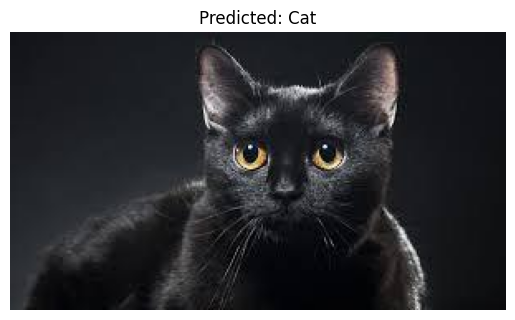

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


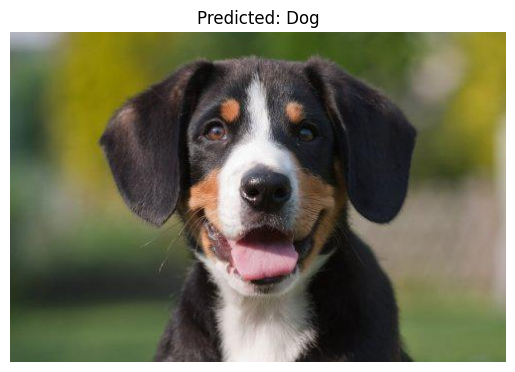

In [12]:
# Example predictions
predict_and_visualize('/kaggle/input/cats-and-dogs-image-classification/train/cats/cat_101.jpg')
predict_and_visualize('/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_283.jpg')